In [1]:
import cv2
import math
import matplotlib.pyplot as plt
#%matplotlib inline
import pandas as pd
import numpy as np
from keras.preprocessing import image
import numpy as np
from keras.utils import np_utils
from skimage.transform import resize
from PIL import Image
import re
import os
import random
import shutil
import keras
from keras.models import load_model

In [2]:
###### SOME KEY PARAMETERS FOR SAMPLING RATES #########
AMOUNT_TRAINING = 107
AMOUNT_TEST = 45
RANDOM_SEED = 5
DOUBLE_TRAINING = AMOUNT_TRAINING * 2
DOUBLE_TEST = AMOUNT_TEST * 2

# 1 for 10 samples, 2 for 20 samples, 3 for 30 samples ...
SAMPLING_RATE = 1
SAMPLING_REPRESENTATION = SAMPLING_RATE * 10
VALIDATION_VALUES_PARAMETER = 0.8


###### IMAGE SIZE in pixels ##################
IMAGE_HEIGHT = 63;
IMAGE_WIDTH = 63;

In [3]:
# Loading video names in a column and labels:
os.getcwd()
path = '/home/alehof/KIMORE_LIFTING_OF_THE_ARMS'

videos = os.listdir(path)

label = []
for i in videos:
    if "incorr" in i:
        label.append(0)
    elif "corr" in i:
        label.append(1)
    else:
        label.append("file_name_incorrect")

videos = pd.DataFrame(videos, label).reset_index()
videos.columns = ["labels", "video_name"]

videos.groupby('labels').count()

,video_name
labels,
0,152
1,152


In [4]:
# Splitting the videos into Train and Test Videos:
incorrect=videos.loc[videos["labels"]==0,]
correct=videos.loc[videos["labels"]==1,]

incorrect_range=np.arange(len(incorrect))
correct_range=np.arange(len(correct))
np.random.seed(RANDOM_SEED)
np.random.shuffle(incorrect_range)
np.random.shuffle(correct_range)

correct=correct.iloc[correct_range,]
incorrect=incorrect.iloc[incorrect_range,]

train_correct=correct.iloc[:AMOUNT_TRAINING,]
train_incorrect=incorrect.iloc[:AMOUNT_TRAINING,]
test_correct=correct.iloc[AMOUNT_TRAINING:,]
test_incorrect=incorrect.iloc[AMOUNT_TRAINING:,]

train_set=train_correct.append(train_incorrect)
test_set=test_correct.append(test_incorrect)

train_set=train_set.reset_index().drop("index",axis=1)
test_set=test_set.reset_index().drop("index",axis=1)

print(train_set.groupby('labels').count())
print(test_set.groupby('labels').count())

        video_name
labels            
0              107
1              107
        video_name
labels            
0               45
1               45


In [5]:
exercises_dir_path = path
train_videos_dir = os.path.join(path, "Train_Videos")
test_videos_dir = os.path.join(path, "Test_Videos")
try:
    os.mkdir(exercises_dir_path)
except FileExistsError as ae:
    print("Folder Already Created")

try:
    os.mkdir(train_videos_dir)
except FileExistsError as ae:
    print("Folder Already Created")

try:
    os.mkdir(test_videos_dir)
except FileExistsError as ae:
    print("Folder Already Created")

Folder Already Created


In [6]:
def video_capturing_function(dataset, folder_name):
    for i in np.arange(len(dataset)):
        video_name = dataset.video_name[i]
        video_read_path = os.path.join(path, video_name)
        cap = cv2.VideoCapture(video_read_path)
        try:
            os.mkdir(os.path.join(os.path.join(path, folder_name),
                                  video_name.split(".")[0]))
        except:
            print("File Already Created")

        train_write_file = os.path.join(os.path.join(path, folder_name),
                                        video_name.split(".")[0])
        cap.set(cv2.CAP_PROP_FPS, 20)
        frameRate = cap.get(5)
        x = 1
        count = 0
        while (cap.isOpened()):
            frameId = cap.get(1)  # current frame number
            ret, frame = cap.read()
            if (ret != True):
                break
            # print(frameRate / 6)
            if (frameId % math.floor(frameRate / SAMPLING_RATE) == 0):
                # if (frameId % math.floor(frameRate) == 0):
                filename = "frame%d.jpg" % count;
                count += 1
                frame_grey = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                cv2.imwrite(os.path.join(train_write_file, filename), frame_grey)
        cap.release()
    return print("All frames written in the: " + folder_name + " Folder")


video_capturing_function(train_set, "Train_Videos")
video_capturing_function(test_set, "Test_Videos")


All frames written in the: Train_Videos Folder
All frames written in the: Test_Videos Folder


In [7]:
# currently not in use
# Code to see how many frames are captured for each video:
train_dir_path='/home/alehof/KIMORE_LIFTING_OF_THE_ARMS/Train_Videos'
test_dir_path='/home/alehof/KIMORE_LIFTING_OF_THE_ARMS/Test_Videos'

vid_file_name=train_set.video_name[0].split('.')[0]

train_frames=[]
for i in np.arange(len(train_set.video_name)):
    vid_file_name=train_set.video_name[i].split('.')[0]
    train_frames.append(len(os.listdir(os.path.join(train_dir_path,vid_file_name))))

test_frames=[]
for i in np.arange(len(test_set.video_name)):
    vid_file_name=test_set.video_name[i].split('.')[0]
    test_frames.append(len(os.listdir(os.path.join(test_dir_path,vid_file_name))))


In [8]:
def frame_generating_function(dataset, dir_path):
    for i in np.arange(len(dataset.video_name)):
        vid_namu = dataset.video_name[i]
        vid_path = os.path.join(dir_path, vid_namu.split(".")[0])
        # print(vid_path)
        len_frame = len(os.listdir(vid_path))
        # print(len_frame)
        # this is an important value (10 i want to utilize 10 frames, maybe i should set this to a constant)
        j = SAMPLING_REPRESENTATION - len(os.listdir(vid_path))
        # print(j)

        if j > 0:
            list_frames = os.listdir(vid_path)
            print(list_frames)
            c = 0
            for k in np.arange(j):
                list_frames = os.listdir(vid_path)
                print(list_frames)
                # print(list_frames)
                frame = os.path.join(vid_path, list_frames[0])
                # print(frame)
                # get the first frame to be coppied
                # print(frame)
                countu = k + len_frame
                new_frame = "frame%d.jpg" % countu
                shutil.copy2(frame, os.path.join(vid_path, new_frame))
                # c+=1
                # omitting this, I intend to only copy the last frame the amount of times i need it and place it at the end.

        else:
            pass
    return print("Frame Generation Done!")


frame_generating_function(train_set, train_dir_path)
frame_generating_function(test_set, test_dir_path)

['frame2.jpg', 'frame1.jpg', 'frame3.jpg', 'frame0.jpg']
['frame2.jpg', 'frame1.jpg', 'frame3.jpg', 'frame0.jpg']
['frame2.jpg', 'frame1.jpg', 'frame4.jpg', 'frame3.jpg', 'frame0.jpg']
['frame2.jpg', 'frame1.jpg', 'frame5.jpg', 'frame4.jpg', 'frame3.jpg', 'frame0.jpg']
['frame2.jpg', 'frame1.jpg', 'frame5.jpg', 'frame4.jpg', 'frame3.jpg', 'frame0.jpg', 'frame6.jpg']
['frame2.jpg', 'frame1.jpg', 'frame5.jpg', 'frame4.jpg', 'frame3.jpg', 'frame0.jpg', 'frame6.jpg', 'frame7.jpg']
['frame2.jpg', 'frame1.jpg', 'frame5.jpg', 'frame4.jpg', 'frame3.jpg', 'frame8.jpg', 'frame0.jpg', 'frame6.jpg', 'frame7.jpg']
['frame2.jpg', 'frame1.jpg', 'frame3.jpg', 'frame0.jpg']
['frame2.jpg', 'frame1.jpg', 'frame3.jpg', 'frame0.jpg']
['frame2.jpg', 'frame1.jpg', 'frame4.jpg', 'frame3.jpg', 'frame0.jpg']
['frame2.jpg', 'frame1.jpg', 'frame5.jpg', 'frame4.jpg', 'frame3.jpg', 'frame0.jpg']
['frame2.jpg', 'frame1.jpg', 'frame5.jpg', 'frame4.jpg', 'frame3.jpg', 'frame0.jpg', 'frame6.jpg']
['frame2.jpg', 'frame1

['frame2.jpg', 'frame1.jpg', 'frame5.jpg', 'frame4.jpg', 'frame3.jpg', 'frame0.jpg', 'frame6.jpg']
['frame2.jpg', 'frame1.jpg', 'frame5.jpg', 'frame4.jpg', 'frame3.jpg', 'frame0.jpg', 'frame6.jpg', 'frame7.jpg']
['frame2.jpg', 'frame1.jpg', 'frame5.jpg', 'frame4.jpg', 'frame3.jpg', 'frame8.jpg', 'frame0.jpg', 'frame6.jpg', 'frame7.jpg']
['frame2.jpg', 'frame1.jpg', 'frame4.jpg', 'frame3.jpg', 'frame0.jpg']
['frame2.jpg', 'frame1.jpg', 'frame4.jpg', 'frame3.jpg', 'frame0.jpg']
['frame2.jpg', 'frame1.jpg', 'frame5.jpg', 'frame4.jpg', 'frame3.jpg', 'frame0.jpg']
['frame2.jpg', 'frame1.jpg', 'frame5.jpg', 'frame4.jpg', 'frame3.jpg', 'frame0.jpg', 'frame6.jpg']
['frame2.jpg', 'frame1.jpg', 'frame5.jpg', 'frame4.jpg', 'frame3.jpg', 'frame0.jpg', 'frame6.jpg', 'frame7.jpg']
['frame2.jpg', 'frame1.jpg', 'frame5.jpg', 'frame4.jpg', 'frame3.jpg', 'frame8.jpg', 'frame0.jpg', 'frame6.jpg', 'frame7.jpg']
['frame2.jpg', 'frame1.jpg', 'frame4.jpg', 'frame3.jpg', 'frame0.jpg']
['frame2.jpg', 'frame1.j

In [9]:
# some troubles detected, folder incorrect respectively correct is created but no files placed, that is why error index out of range occurs,
# can be overcome if another exercise is copied in the respective folder

In [10]:
# Train and Validation Splitting:
label_1_dat=train_set.loc[train_set["labels"]==1,]
label_0_dat=train_set.loc[train_set["labels"]==0,]

train_len_label1=math.floor(len(label_1_dat)*VALIDATION_VALUES_PARAMETER)
train_len_label0=math.floor(len(label_0_dat)*VALIDATION_VALUES_PARAMETER)

train_dat_label1=label_1_dat.iloc[:train_len_label1,]
train_dat_label0=label_0_dat.iloc[:train_len_label0,]

validation_dat_label1=label_1_dat.iloc[train_len_label1:,]
validation_dat_label0=label_0_dat.iloc[train_len_label0:,]

train_vid_dat=train_dat_label1.append(train_dat_label0,ignore_index=True)
validation_vid_dat=validation_dat_label1.append(validation_dat_label0,ignore_index=True)

In [11]:

print(len(label_1_dat))

107


In [12]:
# Data load function for 10 frames:

def data_load_function_SAMPLING_REPRESENTATION_frames(dataset,directory):
    frames=[]
    for i in np.arange(len(dataset)):
        vid_name=dataset.video_name[i].split(".")[0]
        vid_dir_path=os.path.join(directory,vid_name)
        frames_to_select=[]
        for l in np.arange(0,SAMPLING_REPRESENTATION):
            frames_to_select.append('frame%d.jpg' % l)
        vid_data=[]
        for frame in frames_to_select:
            image=Image.open(os.path.join(vid_dir_path,frame))
            image=image.resize((IMAGE_HEIGHT, IMAGE_WIDTH), Image.ANTIALIAS)
            datu=np.asarray(image)
            normu_dat=datu/255
            vid_data.append(normu_dat)
        vid_data=np.array(vid_data)
        frames.append(vid_data)
    return np.array(frames)


In [13]:
# frames train,validation and test data:

test_dataset_new=data_load_function_SAMPLING_REPRESENTATION_frames(test_set, test_dir_path)
train_dataset_new=data_load_function_SAMPLING_REPRESENTATION_frames(train_vid_dat, train_dir_path)
validation_dataset_new= data_load_function_SAMPLING_REPRESENTATION_frames(validation_vid_dat, train_dir_path)

test_labels=np.array(test_set.labels)
train_labels=np.array(train_vid_dat.labels)
validation_labels=np.array(validation_vid_dat.labels)

In [14]:
print(validation_labels)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0]


In [15]:
INTEGER_RESULT =  (math.floor(AMOUNT_TRAINING*VALIDATION_VALUES_PARAMETER))*2
INTEGER_RESULT_2 = (math.ceil((AMOUNT_TRAINING*(1 - VALIDATION_VALUES_PARAMETER))))*2
# Reshaping tensors to confirm with the model we are going to train:
test_dataset_new=test_dataset_new.reshape((AMOUNT_TEST*2,SAMPLING_REPRESENTATION,IMAGE_HEIGHT,IMAGE_WIDTH,1))
train_dataset_new=train_dataset_new.reshape((INTEGER_RESULT,SAMPLING_REPRESENTATION,IMAGE_HEIGHT,IMAGE_WIDTH,1))
validation_dataset_new=validation_dataset_new.reshape((INTEGER_RESULT_2,SAMPLING_REPRESENTATION,IMAGE_HEIGHT,IMAGE_WIDTH,1))
print(train_dataset_new)
print(train_labels)

[[[[[0.        ]
    [0.        ]
    [0.        ]
    ...
    [0.        ]
    [0.        ]
    [0.        ]]

   [[0.        ]
    [0.        ]
    [0.        ]
    ...
    [0.        ]
    [0.        ]
    [0.        ]]

   [[0.        ]
    [0.        ]
    [0.        ]
    ...
    [0.        ]
    [0.        ]
    [0.        ]]

   ...

   [[0.        ]
    [0.        ]
    [0.        ]
    ...
    [0.        ]
    [0.        ]
    [0.        ]]

   [[0.        ]
    [0.        ]
    [0.        ]
    ...
    [0.        ]
    [0.        ]
    [0.        ]]

   [[0.        ]
    [0.        ]
    [0.        ]
    ...
    [0.        ]
    [0.        ]
    [0.        ]]]


  [[[0.83921569]
    [0.85882353]
    [0.7254902 ]
    ...
    [0.2       ]
    [0.26666667]
    [0.3372549 ]]

   [[0.85490196]
    [0.85490196]
    [0.83921569]
    ...
    [0.2       ]
    [0.26666667]
    [0.36470588]]

   [[0.8627451 ]
    [0.8627451 ]
    [0.8627451 ]
    ...
    [0.20392157]
    [0.28235294]
 

In [16]:
## important to consider exercise numbers, as above 80 % of training will stay training data
## 20 % will become validation data 
## therefore considering the 140 videos i had
## i had 98 in training data folder. and 42 in test data folder
## 98 * 0,2 = 20 rounded, + 98*0,8 = 78 rounded (math floor), now it matches up.

## new try with 80% - 20 %

# 110 and 28



#####
# amount training 214 80 % / 20 %


In [17]:
baseline_predictions=np.ones(len(test_labels))
test_accuracy_naive=np.where(baseline_predictions==test_labels)[0].shape[0]/len(test_labels)
test_accuracy_naive

0.5

In [18]:
#now standard simple CNN and LSTM basic architecture


In [19]:
import gc
from tensorflow.keras import backend as k
from tensorflow.keras.callbacks import Callback

In [20]:
class ClearMemory(Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        k.clear_session()

In [21]:
##### REASSIGNING TYPE CONVERSION NEEDED FOR ALL MODELS
train_dataset_new=np.asarray(train_dataset_new).astype(np.float32)
train_labels=np.asarray(train_labels).astype(np.float32)
validation_dataset_new=np.asarray(validation_dataset_new).astype(np.float32)
validation_labels=np.asarray(validation_labels).astype(np.float32)
test_dataset_new=np.asarray(test_dataset_new).astype(np.float32)
test_labels=np.asarray(test_labels).astype(np.float32)
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")

Evaluate on test data


In [22]:

import tensorflow as tf
tf.config.list_physical_devices('GPU')


[]

In [23]:
##### 3D CNN Architecture:


In [29]:
from keras.layers import Conv3D, MaxPooling3D, BatchNormalization, Dropout, Dense, Flatten, concatenate
from keras.models import Model
from keras import Input
# 3D Convolutional Model:
input_model=Input(shape=(SAMPLING_REPRESENTATION, IMAGE_HEIGHT, IMAGE_WIDTH, 1))
layer=Conv3D(32,(3,3,3),strides=(1,1,1),activation='relu')(input_model)
layer=MaxPooling3D((2,2,2))(layer)
layer=Conv3D(64,(3,3,3),strides=(1,1,1),activation='relu')(layer)
layer=MaxPooling3D((2,2,2))(layer)
layer=BatchNormalization()(layer)
layer=Flatten()(layer)
layer=Dense(128,activation='relu')(layer)
layer=Dropout(0.1)(layer)
layer=Dense(64,activation='relu')(layer)
layer=Dense(32,activation='relu')(layer)
layer_output=Dense(1,activation='sigmoid')(layer)

model_3dConv=Model(input_model,layer_output)

model_3dConv.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 10, 63, 63, 1)]   0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 8, 61, 61, 32)     896       
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 4, 30, 30, 32)     0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 2, 28, 28, 64)     55360     
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 1, 14, 14, 64)     0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 14, 14, 64)     256       
_________________________________________________________________
flatten_1 (Flatten)          (None, 12544)             0   

In [30]:
##### MODEL _ KEYPARAMETERS

FACTOR = 0.1
PATIENCE = 4
BATCH_SIZE = 4
EPOCHS = 30

##### USING TIME TO STORE MODEL NAME
import time
timestr = time.strftime("%Y%m%d-%H%M%S")



FILEPATH = 'cnn_lstm_model_3_KIMORE_' + timestr + '.h5'
print(FILEPATH)

cnn_lstm_model_3_KIMORE_20210726-084834.h5


In [31]:
# Conv3d model training:
from keras import optimizers
#optimizer_new=optimizers.RMSprop(lr=0.1)
optimizer_adagrad=keras.optimizers.Adagrad(lr=0.01)
callbacks_list_conv_3d=[keras.callbacks.EarlyStopping(
monitor='acc',patience=PATIENCE),
               keras.callbacks.ModelCheckpoint(
               filepath=FILEPATH,
               monitor='val_loss',
               save_best_only=True),
                        keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = FACTOR, patience = PATIENCE)
               ]
model_3dConv.compile(optimizer=optimizer_adagrad,loss='binary_crossentropy',metrics=['acc'])
conv_3d_model_history=model_3dConv.fit(train_dataset_new,train_labels,batch_size=BATCH_SIZE,epochs=EPOCHS,
               validation_data=(validation_dataset_new,validation_labels),
               callbacks=callbacks_list_conv_3d)

/home/alehof/BA2_action_recogntion/BA2/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/30
43/43 [==============================] - 15s 323ms/step - loss: 0.4649 - acc: 0.8067 - val_loss: 0.5657 - val_acc: 0.5000
Epoch 2/30
43/43 [==============================] - 13s 311ms/step - loss: 0.0160 - acc: 0.9984 - val_loss: 0.4751 - val_acc: 0.9545
Epoch 3/30
43/43 [==============================] - 13s 310ms/step - loss: 0.0723 - acc: 0.9777 - val_loss: 0.3627 - val_acc: 0.9773
Epoch 4/30
43/43 [==============================] - 13s 311ms/step - loss: 0.0663 - acc: 0.9837 - val_loss: 0.2271 - val_acc: 0.9773
Epoch 5/30
43/43 [==============================] - 13s 312ms/step - loss: 0.0083 - acc: 0.9990 - val_loss: 0.1882 - val_acc: 0.9773
Epoch 6/30
43/43 [==============================] - 13s 311ms/step - loss: 0.0417 - acc: 0.9755 - val_loss: 0.1458 - val_acc: 0.9773


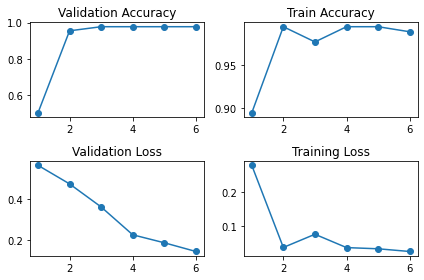

In [32]:
acc=conv_3d_model_history.history["acc"]
val_acc=conv_3d_model_history.history["val_acc"]
loss=conv_3d_model_history.history["loss"]
val_loss=conv_3d_model_history.history["val_loss"]


epochs=np.arange(1,7)

plt.figure()
plt.subplot(2,2,1)
plt.plot(epochs,val_acc,'-o')
plt.title('Validation Accuracy')

plt.subplot(2,2,2)
plt.plot(epochs,acc,'-o')
plt.title('Train Accuracy')

plt.subplot(2,2,3)
plt.plot(epochs,val_loss,'-o')
plt.title('Validation Loss')

plt.subplot(2,2,4)
plt.plot(epochs,loss,'-o')
plt.title('Training Loss')


plt.tight_layout()

In [33]:
#modelu_6=load_model('stretch_model_conv_3d_new4.h5')
modelu_6=load_model(FILEPATH)
modelu_6.evaluate(test_dataset_new,test_labels)

3/3 [==============================] - 1s 122ms/step - loss: 0.1032 - acc: 0.9889


[0.10324141383171082, 0.9888888597488403]

In [ ]:
#Loading the two best models:

In [ ]:
modelu_cnlst_1=modelu_5
modelu_cnlst_2=modelu_6
# since they were already loaded -> the model names need to be manually asigned here 
#modelu_cnlst_1=load_model('cnn_lstm_model_new3.h5')
#modelu_cnlst_2=load_model('cnn_lstm_model_new4.h5')

In [ ]:
#Video Folder Create Function:¶
video_list=os.listdir(os.path.join(path,'Realtime_Videos'))

print(video_list)